In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing

### Part 1: Data Preparation and Exploration

In [3]:
df=pd.read_csv("exchange_rate.csv",parse_dates=True,index_col='date')

In [4]:
df

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [5]:
df.isnull().sum()        ### Checking for the Null Values

Ex_rate    0
dtype: int64

Text(0, 0.5, 'Ex_rate')

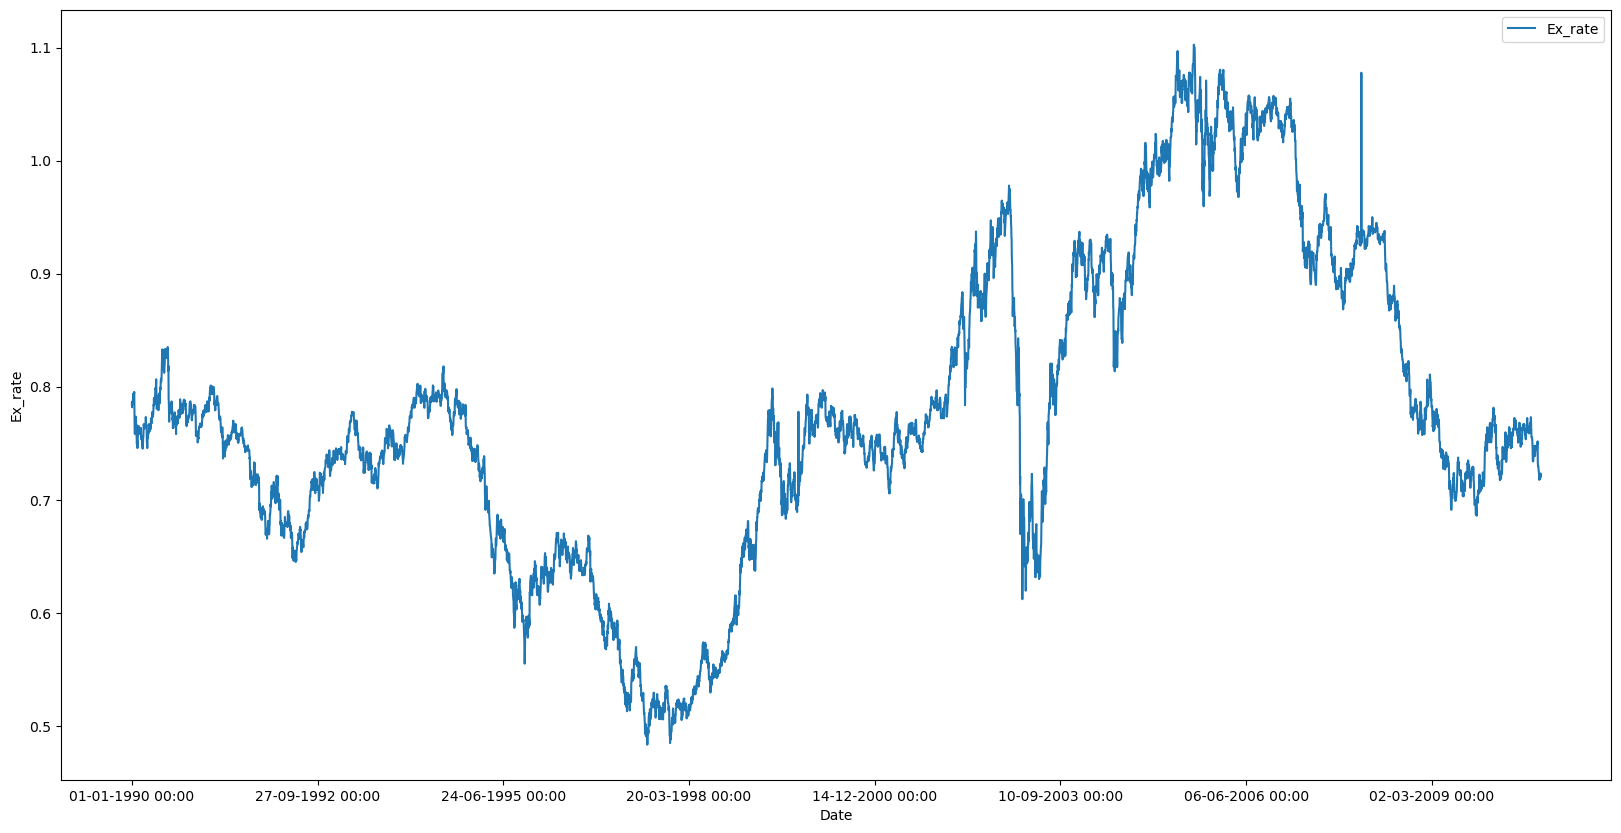

In [6]:
df.plot(figsize=(20,10))  
plt.xlabel('Date')
plt.ylabel('Ex_rate')        ### Checking the model whether it is multipliactive or additive

#### Part 2: Model Building - ARIMA

In [8]:
def test_stationary(timeseries):
    ## Calculating the Rolling mean and Rollind Standard Deviation
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()

    ## Plotting the figure to find the data is stationary or not
    original=plt.plot(timeseries,color='black',label='original')
    mean=plt.plot(rolmean,color='blue',label='rolmean')
    std=plt.plot(rolstd,color='grey',label='rolstd')
    plt.legend(loc='best')

    
    ### Finding Hypothesis testing to find the data is stationary or not
    df_test=adfuller(timeseries)
    my_out=pd.Series(df_test[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_out["Critical Value (%s)"%i]=j
    print(my_out)

Test Statistic                   -1.664994
p-value                           0.449233
#Lags Used                        1.000000
Number of Observations Used    7586.000000
Critical Value (1%)              -3.431212
Critical Value (5%)              -2.861921
Critical Value (10%)             -2.566973
dtype: float64


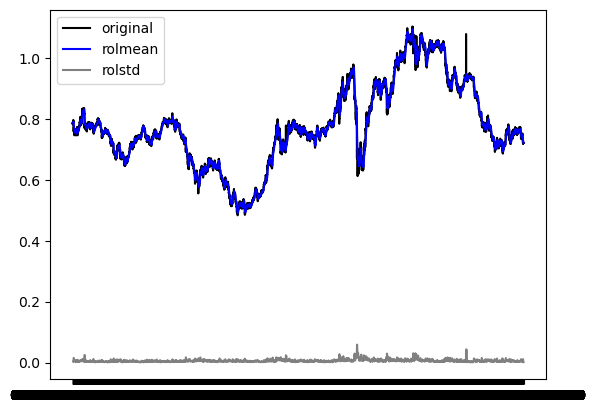

In [9]:
test_stationary(df['Ex_rate'])

In [10]:
df['Diff']=df['Ex_rate']-df['Ex_rate'].shift(30)    ## Data is not Stationary that is why we are making the data into stationary

In [11]:
df

,Ex_rate,Diff
date,,
01-01-1990 00:00,0.785500,NaN
02-01-1990 00:00,0.781800,NaN
03-01-1990 00:00,0.786700,NaN
04-01-1990 00:00,0.786000,NaN
05-01-1990 00:00,0.784900,NaN
...,...,...
06-10-2010 00:00,0.718494,-0.029337
07-10-2010 00:00,0.721839,-0.024597
08-10-2010 00:00,0.723197,-0.015465


In [12]:
df.dropna(inplace=True)     ### Removing Missing Values

In [13]:
df

,Ex_rate,Diff
date,,
31-01-1990 00:00,0.745700,-0.039800
01-02-1990 00:00,0.750000,-0.031800
02-02-1990 00:00,0.756700,-0.030000
03-02-1990 00:00,0.759500,-0.026500
04-02-1990 00:00,0.758600,-0.026300
...,...,...
06-10-2010 00:00,0.718494,-0.029337
07-10-2010 00:00,0.721839,-0.024597
08-10-2010 00:00,0.723197,-0.015465


Test Statistic                -9.289170e+00
p-value                        1.192623e-15
#Lags Used                     3.100000e+01
Number of Observations Used    7.526000e+03
Critical Value (1%)           -3.431219e+00
Critical Value (5%)           -2.861924e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


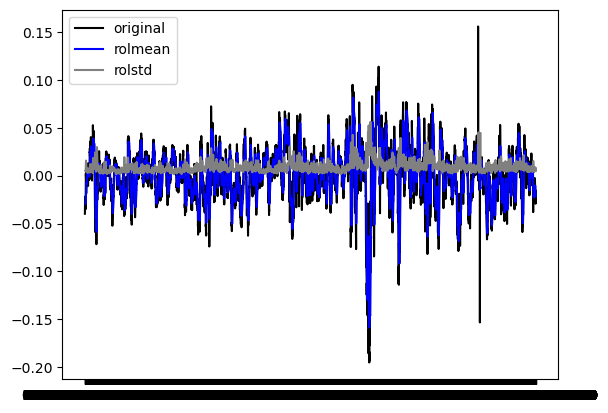

In [14]:
### Now Checking Whether the data is stationary or not
test_stationary(df['Diff'])

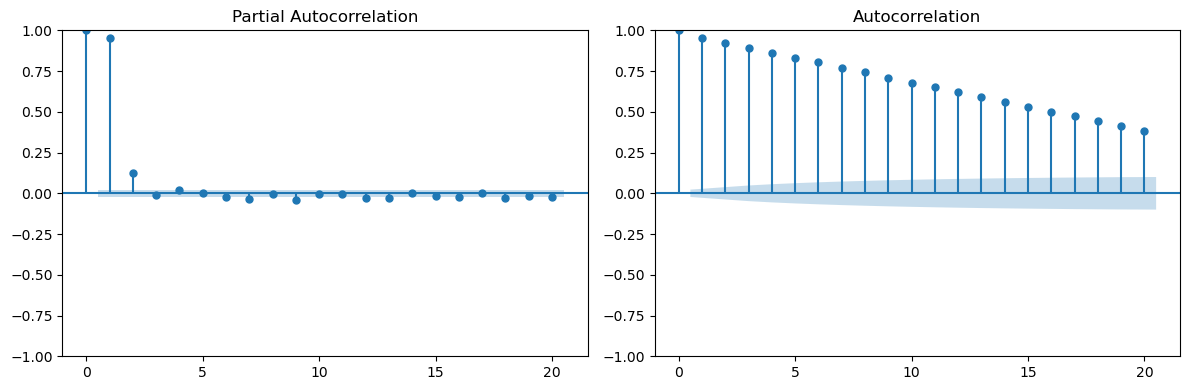

In [15]:
fig,axes=plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_pacf(df['Diff'],lags=20,ax=axes[0])   #### Checking for p-value 
smt.graphics.plot_acf(df['Diff'],lags=20,ax=axes[1])    #### checking for q-value
plt.tight_layout()

In [16]:
model=ARIMA(df['Ex_rate'],order=(2,2,1))      ## Building the ARIMA Model

In [17]:
result=model.fit()                         ### Fitting the model

In [18]:
forecast=result.forecast(20)        
forecast                                           ### Predicting the Future values

2010-10-11    0.720680
2010-10-12    0.720548
2010-10-13    0.720415
2010-10-14    0.720281
2010-10-15    0.720148
2010-10-16    0.720015
2010-10-17    0.719882
2010-10-18    0.719749
2010-10-19    0.719616
2010-10-20    0.719483
2010-10-21    0.719349
2010-10-22    0.719216
2010-10-23    0.719083
2010-10-24    0.718950
2010-10-25    0.718817
2010-10-26    0.718684
2010-10-27    0.718550
2010-10-28    0.718417
2010-10-29    0.718284
2010-10-30    0.718151
Freq: D, Name: predicted_mean, dtype: float64

In [19]:
df["Forecast"]=result.predict()             

In [20]:
df.dropna(inplace=True)

In [21]:
df

,Ex_rate,Diff,Forecast
date,,,
31-01-1990 00:00,0.745700,-0.039800,0.000000
02-02-1990 00:00,0.756700,-0.030000,0.754300
03-02-1990 00:00,0.759500,-0.026500,0.746873
04-02-1990 00:00,0.758600,-0.026300,0.758907
05-02-1990 00:00,0.764600,-0.022000,0.786345
...,...,...,...
06-10-2010 00:00,0.718494,-0.029337,0.751479
07-10-2010 00:00,0.721839,-0.024597,0.764233
08-10-2010 00:00,0.723197,-0.015465,0.760126


In [22]:
mean_absolute_error(df['Ex_rate'],df['Forecast'])

0.017178111342091414

### Part 3: Model Building - Exponential Smoothing

In [24]:
simple=SimpleExpSmoothing(df['Ex_rate']).fit(smoothing_level=0.5)       ## For Simple Exponential Smoothing

In [25]:
simple.fittedvalues                                                      ### Predicted values

date
31-01-1990 00:00    0.745700
02-02-1990 00:00    0.745700
03-02-1990 00:00    0.751200
04-02-1990 00:00    0.755350
05-02-1990 00:00    0.756975
                      ...   
06-10-2010 00:00    0.719158
07-10-2010 00:00    0.718826
08-10-2010 00:00    0.720332
09-10-2010 00:00    0.721765
10-10-2010 00:00    0.721295
Length: 7529, dtype: float64

In [26]:
df["SES"]=SimpleExpSmoothing(df['Ex_rate']).fit(smoothing_level=0.5).fittedvalues       ## putting into the data

In [27]:
df

,Ex_rate,Diff,Forecast,SES
date,,,,
31-01-1990 00:00,0.745700,-0.039800,0.000000,0.745700
02-02-1990 00:00,0.756700,-0.030000,0.754300,0.745700
03-02-1990 00:00,0.759500,-0.026500,0.746873,0.751200
04-02-1990 00:00,0.758600,-0.026300,0.758907,0.755350
05-02-1990 00:00,0.764600,-0.022000,0.786345,0.756975
...,...,...,...,...
06-10-2010 00:00,0.718494,-0.029337,0.751479,0.719158
07-10-2010 00:00,0.721839,-0.024597,0.764233,0.718826
08-10-2010 00:00,0.723197,-0.015465,0.760126,0.720332


In [28]:
k=simple.forecast(20)

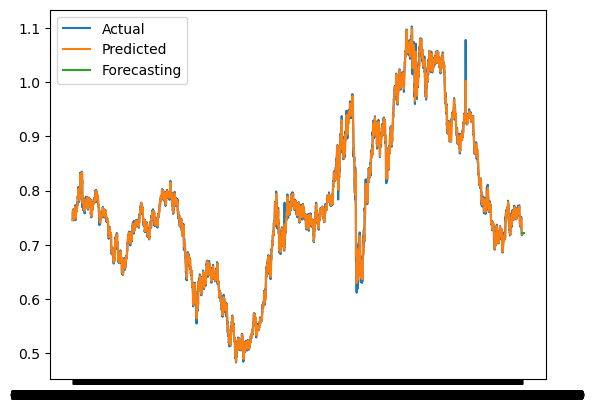

In [29]:
plt.plot(df['Ex_rate'],label='Actual')
plt.plot(df['SES'],label='Predicted')          ### plotting the simple Exponential smoothing
plt.plot(k,label='Forecasting')
plt.legend(loc='best')
plt.show()

In [30]:
double=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative').fit(smoothing_level=0.5,smoothing_trend=0.2)    ### For Double Exponential Smoothing

In [31]:
double.fittedvalues               ### Predicted Values

date
31-01-1990 00:00    0.751890
02-02-1990 00:00    0.750002
03-02-1990 00:00    0.755239
04-02-1990 00:00    0.759696
05-02-1990 00:00    0.761370
                      ...   
06-10-2010 00:00    0.716579
07-10-2010 00:00    0.716706
08-10-2010 00:00    0.718955
09-10-2010 00:00    0.721183
10-10-2010 00:00    0.721075
Length: 7529, dtype: float64

In [32]:
d_forecast=double.forecast(20)                  ## Predicting the future values

In [33]:
df['DES']=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative').fit(smoothing_level=0.5,smoothing_trend=0.2).fittedvalues

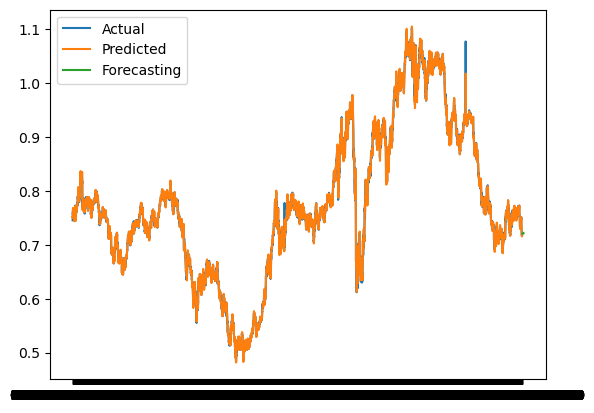

In [34]:
plt.plot(df['Ex_rate'],label='Actual')
plt.plot(df['DES'],label='Predicted')
plt.plot(d_forecast,label='Forecasting')
plt.legend(loc='best')
plt.show()

In [35]:
triple=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative',seasonal='multiplicative',seasonal_periods=12).fit(smoothing_level=0.2,smoothing_trend=0.5,smoothing_seasonal=0.4)

In [36]:
t_forecast=triple.forecast(20)

In [37]:
triple.fittedvalues

date
31-01-1990 00:00    0.750803
02-02-1990 00:00    0.752965
03-02-1990 00:00    0.756084
04-02-1990 00:00    0.757420
05-02-1990 00:00    0.762692
                      ...   
06-10-2010 00:00    0.706875
07-10-2010 00:00    0.713520
08-10-2010 00:00    0.719335
09-10-2010 00:00    0.724060
10-10-2010 00:00    0.727145
Length: 7529, dtype: float64

In [38]:
df['TES']=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative',seasonal='multiplicative',seasonal_periods=12).fit(smoothing_level=0.2,smoothing_trend=0.5,smoothing_seasonal=0.4).fittedvalues

In [39]:
df

,Ex_rate,Diff,Forecast,SES,DES,TES
date,,,,,,
31-01-1990 00:00,0.745700,-0.039800,0.000000,0.745700,0.751890,0.750803
02-02-1990 00:00,0.756700,-0.030000,0.754300,0.745700,0.750002,0.752965
03-02-1990 00:00,0.759500,-0.026500,0.746873,0.751200,0.755239,0.756084
04-02-1990 00:00,0.758600,-0.026300,0.758907,0.755350,0.759696,0.757420
05-02-1990 00:00,0.764600,-0.022000,0.786345,0.756975,0.761370,0.762692
...,...,...,...,...,...,...
06-10-2010 00:00,0.718494,-0.029337,0.751479,0.719158,0.716579,0.706875
07-10-2010 00:00,0.721839,-0.024597,0.764233,0.718826,0.716706,0.713520
08-10-2010 00:00,0.723197,-0.015465,0.760126,0.720332,0.718955,0.719335


### Part 4: Evaluation and Comparison

In [41]:
rmse_triple=np.sqrt(mean_squared_error(df['Ex_rate'],df['TES'])).round(2)   ### RMSE value
mae_triple=mean_absolute_error(df['Ex_rate'],df['TES']).round(2)            ### MAE Value
mape_triple=round(mean_absolute_percentage_error(df['Ex_rate'],df['TES'])*100,2)  ### MAPE Values

In [42]:
rmse_triple,mae_triple,mape_triple

(0.01, 0.01, 1.21)

In [ ]:
rmse_arima=np.sqrt(mean_squared_error(df['Ex_rate'],df['Forecast'])).round(2)
mae_arima=mean_absolute_error(df['Ex_rate'],df['Forecast']).round(2)
mape_arima=round(mean_absolute_percentage_error(df['Ex_rate'],df['Forecast'])*100,2)

In [ ]:
rmse_arima,mae_arima,mape_arima

(0.04, 0.02, 2.25)

In [ ]:
results = pd.DataFrame({'Method':['RMSE','MAE','MAPE'], 'Exponential_Smoothing':[rmse_triple,mae_triple,mape_triple],
                        'ARIMA':[rmse_arima,mae_arima,mape_arima]})
results

,Method,Exponential_Smoothing,ARIMA
0,RMSE,0.01,0.04
1,MAE,0.01,0.02
2,MAPE,1.21,2.25


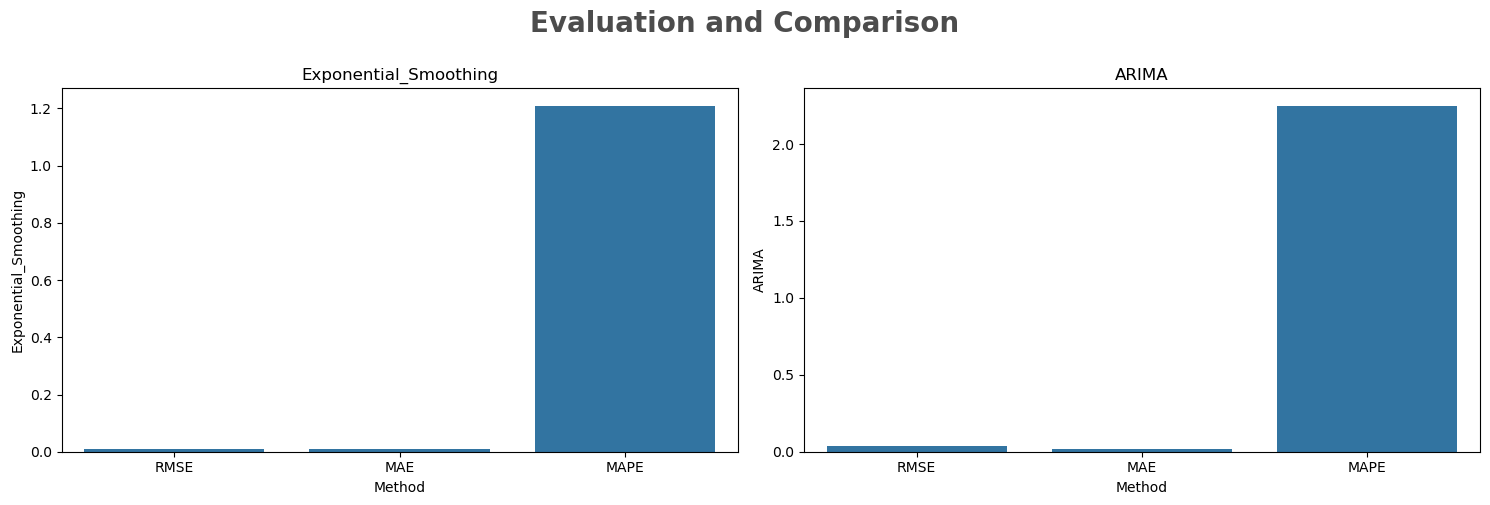

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Evaluation and Comparison',size=20,y=(1),fontweight='bold',alpha=0.7)
sns.barplot(ax=axes[0], x=results.Method, y=results.Exponential_Smoothing)
axes[0].set_title('Exponential_Smoothing')
sns.barplot(ax=axes[1], x=results.Method, y=results.ARIMA)
axes[1].set_title('ARIMA')
plt.tight_layout();

In [ ]:
### ARIMA: Captures autocorrelation but may struggle with non-stationary data without differencing.
### Exponential Smoothing: Better for trends and seasonality but may be less accurate for sudden shifts.

In [ ]:
### The Two models are Performing good but better to go with Exponential Smoothing because it is perfect for Seasonal data